In [9]:
import numpy as np
from keras.datasets import mnist
import os
import pickle

In [10]:
# 加载MNIST数据集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#数据集处理
x_train = x_train[0:10000]/255.0
x_test = x_test[0:6000]/255.0
x_train = x_train.reshape(10000,1,28,28)
x_test = x_test.reshape(6000,1,28,28)
#转化为onehot标签
onehot = np.identity(10)
y_train = onehot[y_train[:10000]]
y_test = onehot[y_test[:6000]]

In [11]:
def im2col(input_data,kernel_size, stride=1, pad=0):
    #im2col函数将输入的图片数据转化为col
    N, C, H, W = input_data.shape
    filter_h = kernel_size
    filter_w = kernel_size
    out_h = (H + 2*pad - filter_h)//stride + 1 #将卷积核的大小赋值 
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad,pad), (pad,pad)], 'constant')  #填充操作
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w)) #初始化

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, kernel_size, stride=1, pad=0):
    #col2im是im2col的逆操作
    N, C, H, W = input_shape
    filter_h = kernel_size
    filter_w = kernel_size
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [12]:
import numpy as np

class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.t = 0
        self.m = 0
        self.v = 0
        
        # 初始化卷积核权重和偏置
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)*0.01
        self.bias = np.zeros((out_channels, 1))
        
        # 初始化用于反向传播的中间变量
        self.x = None
        self.col_x = None
        self.col_weight = None
        self.dweight = None
        self.dbias = None
        
    def forward(self, x):
        # 输入x的维度为 (batch_size, in_channels, height, width)
        batch_size, in_channels, in_height, in_width = x.shape
        
        # 计算输出特征图的大小
        out_height = int((in_height + 2 * self.padding - self.kernel_size) / self.stride + 1)
        out_width = int((in_width + 2 * self.padding - self.kernel_size) / self.stride + 1)
        
        # 使用im2col函数将输入x变换为二维矩阵col_x
        self.col_x = im2col(x, self.kernel_size, self.stride, self.padding)
        
        # 使用reshape函数将卷积核权重变换为二维矩阵col_weight
        self.col_weight = self.weights.reshape(self.out_channels, -1).T
        
        # 计算卷积的结果
        out = np.dot(self.col_x, self.col_weight) + self.bias.T
        
        # 将结果重塑为输出特征图的形状
        out = out.reshape(batch_size, out_height, out_width, self.out_channels)
        out = out.transpose(0, 3, 1, 2)
        
        # 保存用于反向传播的中间变量
        self.x = x
        
        return out
    
    def backward(self, dout,learning_rate):
        # 输入dout的维度为 (batch_size, out_channels, out_height, out_width)
        dout = dout.transpose(0, 2, 3, 1)
        
        # 使用reshape函数将dout变换为二维矩阵
        dout = dout.reshape(-1, self.out_channels)
        
        # 计算卷积核权重的梯度
        self.dweight = np.dot(self.col_x.T, dout)
        self.dweight = self.dweight.transpose(1, 0).reshape(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        
        # 计算偏置的梯度
        self.dbias = np.sum(dout, axis=0, keepdims=True)
        
        # 计算输入x的梯度
        dcol_x = np.dot(dout, self.col_weight.T)
        dx = col2im(dcol_x, self.x.shape, self.kernel_size, self.stride, self.padding)
        
        #Adam算法
        eps = 1e-8
        beta1 = 0.9
        beta2 = 0.999
        self.t += 1
        self.m = beta1 * self.m + (1 - beta1) * self.dweight
        self.v = beta2 * self.v + (1 - beta2) * self.dweight ** 2
        m_hat = self.m / (1 - beta1 ** self.t)
        v_hat = self.v / (1 - beta2 ** self.t)
        self.weights -= learning_rate * m_hat / (np.sqrt(v_hat) + eps)
        self.bias -= learning_rate * self.dbias.T      
        return dx
    
    def save(self, file_name): #save和load用以保存训练完成的权重和偏置，此后相同，不再赘述
        #保存为.npy格式
        np.savez(file_name, weights=self.weights, bias=self.bias)

    def load(self, file_name):
        #将.npy读入
        data = np.load(file_name)
        self.weights = data['weights']
        self.bias = data['bias']
        
class ReLU:
    #ReLU激活函数的实现
    def __init__(self):
        self.mask = None
    

    def forward(self, x):
        self.mask = x <= 0 #mask用于保存x<=0的位置，方便方向传播运算
        out = x.copy()
        out[self.mask] = 0 #小于0的位置赋值为0
        #print(np.shape(out))
        return out
    

    def backward(self, dout): #ReLU的反向传播较为简单，x<0处为0，x>0处直接等于dout
        dout[self.mask] = 0
        dx = dout
        return dx

class MaxPool2D: #最大池化操作
    def __init__(self, pool_size=(2,2), stride=(2,2)):
        #初始化操作
        self.pool_h, self.pool_w = pool_size
        self.stride_h, self.stride_w = stride
        self.cache = None

    def forward(self, x):
        #前向传播
        N, C, H, W = x.shape
        #计算输出的形状
        out_h = int((H - self.pool_h) / self.stride_h + 1)
        out_w = int((W - self.pool_w) / self.stride_w + 1)
        #初始化
        out = np.zeros((N, C, out_h, out_w))
        
        #滑窗最大池化操作
        for h in range(out_h):
            for w in range(out_w):
                #对当前输出格，先将对应位置的最大池化window选出
                h_start, w_start = h*self.stride_h, w*self.stride_w
                h_end, w_end = h_start+self.pool_h, w_start+self.pool_w
                window = x[:, :, h_start:h_end, w_start:w_end]
                #再将对应的最大值赋值给当前输出
                out[:, :, h, w] = np.max(window, axis=(2,3))
        #print(out[0,0])
        #记录数据便于反向传播
        self.cache = x
        return out

    def backward(self, dout):
        #最大池化的反向传播
        x = self.cache
        N, C, H, W = x.shape
        _, _, out_h, out_w = dout.shape
        
        #初始化为0
        dx = np.zeros_like(x)
        
        #最大值处有梯度下降反向传播，其余位置梯度下降为0
        for h in range(out_h):
            for w in range(out_w):
                #和前向相同，先提取出当前的window
                h_start, w_start = h*self.stride_h, w*self.stride_w
                h_end, w_end = h_start+self.pool_h, w_start+self.pool_w
                window = x[:, :, h_start:h_end, w_start:w_end]
                #寻找最大值
                max_value = np.max(window, axis=(2,3))
                max_mask = (window == (max_value)[:,:,None,None])
                #将最大值处的梯度反向传播
                dx[:, :, h_start:h_end, w_start:w_end] += max_mask * (dout[:, :, h, w])[:,:,None,None]

        return dx    
        
class Softmax():
    def __init__(self):
        pass
    def forward(self, input):  
 
        # softmax 计算输出结果
        input_exp = np.exp(input)#生成(n,class)大小的e^(每个类别的概率)
        sum_denominator = np.sum(input_exp,axis=1,keepdims=True)#取每行的和,变成（n,1)
        self.prob = input_exp / sum_denominator#得到softmax最终公式（即属于每一类的概率）,分母（n，1）拓展成（n，c）
        #print(self.prob)
        return self.prob
    
    def get_loss(self,y_onehot):   
        #计算损失
        self.batch_size = self.prob.shape[0]#n
        #构建one-hot标签
        self.y_onehot = y_onehot
        #self.label_onehot = np.zeros_like(self.prob)
        #self.label_onehot[np.arange(self.batch_size), label] = 1.0 #第几个样本最终属于哪一类(概率为1，其他为0)
        #计算交叉熵，此处的1e-9是为了避免出现对0运算的情况
        loss = -np.sum(np.log(self.prob+1e-9) * self.y_onehot) / self.batch_size
        return loss
    
    def backward(self):  
        #反向传播的计算
        #计算本层损失（这边要的是一个梯度矩阵）
        bottom_diff = (self.prob - self.y_onehot)/self.batch_size        
        return bottom_diff


class Accuracy:
    def __init__(self):
        self.acc = None
    
    def acc(self, y_pred, y_true):
        # 计算准确率
        pred_label = np.argmax(y_pred, axis=1)
        true_label = np.argmax(y_true, axis=1)
        #真实标签和预测标签对比
        self.acc = np.sum(pred_label == true_label) / y_pred.shape[0]
        
        return self.acc
    
class FullConect: #全连接
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(1.0 / input_dim)
        self.biases = np.zeros(output_dim)
        self.x_shape = None
        self.d_weights= None
        self.d_biases = None
        self.x = None
        self.t = 0
        self.m = 0
        self.v = 0
        
    def forward(self, x):
        #全连接前向传播
        self.x_shape = x.shape
        #将(N,C,H,W)的后三个维度展平为(N，C*H*W)
        self.x =  x.reshape(x.shape[0],-1) 
        #print(np.shape(self.x))
        
        #前向传播是简单的矩阵乘法运算
        return np.dot(self.x, self.weights) + self.biases
    

    def backward(self, dout,lr):
        learning_rate = lr
        self.d_weights = np.dot(self.x.T, dout)
        self.d_biases = np.sum(dout, axis=0)
        dx = np.dot(dout, self.weights.T)
        dx = dx.reshape(self.x_shape)
        
        #更新权重和偏置
        # Adam算法
        eps = 1e-8
        beta1 = 0.9
        beta2 = 0.999
        self.t += 1
        self.m = beta1 * self.m + (1 - beta1) * self.d_weights
        self.v = beta2 * self.v + (1 - beta2) * self.d_weights ** 2
        m_hat = self.m / (1 - beta1 ** self.t)
        v_hat = self.v / (1 - beta2 ** self.t)
        self.weights -= learning_rate * m_hat / (np.sqrt(v_hat) + eps)
        self.biases -= learning_rate * self.d_biases     
        return dx
    
    def save(self, file_name):
        np.savez(file_name, weights=self.weights, bias=self.biases)

    def load(self, file_name):
        data = np.load(file_name)
        self.weights = data['weights']
        self.biases = data['bias']

In [17]:
class ConvNet:
    def __init__(self):
        # 定义卷积层的超参数       
        self.conv_layer1 = Conv2D(1,16,3)
        self.relu_layer1 = ReLU()
        self.pool_layer1 = MaxPool2D()
        self.conv_layer2 = Conv2D(16, 64, 3)
        self.relu_layer2 = ReLU()
        self.pool_layer2 = MaxPool2D()
        self.fc_layer1 = FullConect(64*7*7,4096)
        self.fc_layer2 = FullConect(4096,1024)
        self.fc_layer3 = FullConect(1024,10)
        self.softmax_layer = Softmax()
        self.learningrate = 0.0001
        
    def forward(self,x):
        out_conv1 = self.conv_layer1.forward(x)
        out_relu1 = self.relu_layer1.forward(out_conv1)
        out_pool1 = self.pool_layer1.forward(out_relu1)
        out_conv2 = self.conv_layer2.forward(out_pool1)
        out_relu2 = self.relu_layer2.forward(out_conv2)
        out_pool2 = self.pool_layer2.forward(out_relu2)
        out_fc1 = self.fc_layer1.forward(out_pool2)
        out_fc2 = self.fc_layer2.forward(out_fc1)
        out_fc3 = self.fc_layer3.forward(out_fc2)
        out_softmax = self.softmax_layer.forward(out_fc3)
        y_pred = self.to_onehot(out_softmax)
        
        return y_pred

    def backward(self,lr):
        d_softmax = self.softmax_layer.backward()
        d_fc3 = self.fc_layer3.backward(d_softmax,0.001)
        d_fc2 = self.fc_layer2.backward(d_fc3,0.0009)
        d_fc1 = self.fc_layer1.backward(d_fc2,0.0005)
        d_pool2 = self.pool_layer2.backward(d_fc1)
        d_relu2 = self.relu_layer2.backward(d_pool2)
        d_conv2 = self.conv_layer2.backward(d_relu2,0.0005)
        d_pool1 = self.pool_layer1.backward(d_conv2)
        d_relu1 = self.relu_layer1.backward(d_pool1)
        d_conv1 = self.conv_layer1.backward(d_relu1,0.0005)

    def to_onehot(self,probs): #softmax转化为onehot标签
        num_samples = probs.shape[0]
        num_classes = probs.shape[1]
        onehot = np.zeros((num_samples, num_classes))
        onehot[np.arange(num_samples), np.argmax(probs, axis=1)] = 1
        return onehot
    
    def predict(self,x):         
        y_pred = self.forward(x)
        y_onehot = self.to_onehot(y_pred)
        return y_onehot,y_pred
    
    def accuracy(self,y_pred, y_true):
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_true, axis=1)
        accuracy = np.mean(y_pred == y_true)
        return accuracy

    def save(self, file_name):
        #保存参数权重的函数
        save_dir = os.path.expanduser('~/model_save')
        #当前路径下
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        #对每一层的参数进行保存
        filepath = os.path.join(save_dir, file_name)
        data = {
            'conv_layer1': self.conv_layer1.save(filepath + "_conv_layer1"),
            'conv_layer2': self.conv_layer2.save(filepath + "_conv_layer2"),
            'fc_layer1': self.fc_layer1.save(filepath + "_fc_layer1"),
            'fc_layer2': self.fc_layer2.save(filepath + "_fc_layer2"),
            'fc_layer3': self.fc_layer3.save(filepath + "_fc_layer3")
        }
        with open(filepath + ".npz", 'wb') as f:
            np.savez(f, **data)
    
    def load(self, file_name):
        #加载权重的函数
        save_dir = os.path.expanduser('~/model_save')
        filepath = os.path.join(save_dir, file_name)
        with np.load(filepath + ".npz") as data:
            self.conv_layer1.load(filepath + "_conv_layer1.npz")
            self.conv_layer2.load(filepath + "_conv_layer2.npz")
            self.fc_layer1.load(filepath + "_fc_layer1.npz")
            self.fc_layer2.load(filepath + "_fc_layer2.npz")
            self.fc_layer3.load(filepath + "_fc_layer3.npz")
            
    def train(self,X,Y,test_X,test_Y):
        lr = self.learningrate
        epochs = 50
        batch_size = 512
        num_samples = X.shape[0]
        num_batches = num_samples // batch_size
        
        train_loss = []
        train_acc = []
        for i in range(epochs):
            epoch_loss = 0
            epoch_acc = 0
            # Shuffle the data for each epoch
            permutation = np.random.permutation(num_samples)
            X = X[permutation]
            Y = Y[permutation]
            
            for j in range(num_batches):
                # 将当前batch的数据选出
                start = j * batch_size
                end = start + batch_size
                X_batch = X[start:end]
                Y_batch = Y[start:end]
                
                #前向传播
                y_pred = self.forward(X_batch)
                
                #计算loss
                loss = self.softmax_layer.get_loss(Y_batch)
                y_pred = self.to_onehot(y_pred)
         
                epoch_loss += loss
            
                #反向传播
                self.backward(lr)

                    
            if i % 1 == 0:
                # 预测测试集上的结果
                test_preds,test_probs = self.predict(test_X)
                # 计算测试集上的准确率
                test_acc = self.accuracy(test_preds,test_Y)
                print("Epoch {}/{}: Train Loss = {:.4f}, Test Accuracy = {:.4f}".format(i+1, epochs, epoch_loss, test_acc))
                train_loss.append(epoch_loss)
                train_acc.append(test_acc)
        return train_loss,train_acc

In [18]:
net = ConvNet()
rain_loss,train_acc = net.train(x_train,y_train,x_test,y_test)

Epoch 1/50: Train Loss = 27.9501, Test Accuracy = 0.7772
Epoch 2/50: Train Loss = 8.6342, Test Accuracy = 0.8928
Epoch 3/50: Train Loss = 4.9145, Test Accuracy = 0.9240
Epoch 4/50: Train Loss = 3.2389, Test Accuracy = 0.9552
Epoch 5/50: Train Loss = 2.4038, Test Accuracy = 0.9588
Epoch 6/50: Train Loss = 1.8972, Test Accuracy = 0.9623
Epoch 7/50: Train Loss = 1.5602, Test Accuracy = 0.9658
Epoch 8/50: Train Loss = 1.2336, Test Accuracy = 0.9612
Epoch 9/50: Train Loss = 1.1211, Test Accuracy = 0.9697
Epoch 10/50: Train Loss = 0.9294, Test Accuracy = 0.9722
Epoch 11/50: Train Loss = 0.7257, Test Accuracy = 0.9740
Epoch 12/50: Train Loss = 0.6041, Test Accuracy = 0.9740
Epoch 13/50: Train Loss = 0.5219, Test Accuracy = 0.9688
Epoch 14/50: Train Loss = 0.5448, Test Accuracy = 0.9710
Epoch 15/50: Train Loss = 0.4187, Test Accuracy = 0.9715
Epoch 16/50: Train Loss = 0.6039, Test Accuracy = 0.9710
Epoch 17/50: Train Loss = 0.4940, Test Accuracy = 0.9650
Epoch 18/50: Train Loss = 0.3267, Test 

In [96]:
filename = '01'
net.save(filename)

In [97]:
net.load(filename)

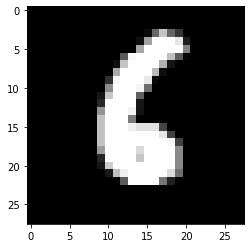

In [20]:
import matplotlib.pyplot as plt 
plt.imshow(x_train[9500][0],cmap=plt.get_cmap('gray'))